In [33]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tkinter import *
from PIL import Image, ImageTk

In [34]:
# '2' in variables usually means 'to', such as h12h2, which means h1 to h2

In [35]:
img_h1 = cv.imread('img/h1.jpg')
cv.imwrite('img/h1_1.jpg', cv.resize(img_h1, (500, 500)))

True

In [36]:
loc = Tk()
nodes = []
loc.geometry("950x750")
loc.title("part2")
canvas = Canvas(loc, width=950, height=800, bg='white', )
canvas.pack()

img_h1 = Image.open('img/h1_1.jpg')
img_h2 = Image.open('img/h2.jpg')
img_h1_tk = ImageTk.PhotoImage(img_h1)
img_h2_tk = ImageTk.PhotoImage(img_h2)


def modify_img():
    if not img_h2_tk:
        raise ValueError("img_h2_tk is None")
    canvas.itemconfig(img_canvas, image=img_h2_tk)
    canvas.itemconfig(text_canvas, text="You need to click 4 points on h2")


img_canvas = canvas.create_image(0, 0, image=img_h1_tk, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
text_canvas = canvas.create_text(200, 620, text="You need to click 4 points on h1", font=("Arial", 15))
canvas.create_text(180, 670, text="Position of points:", font=("Arial", 15))

e2c = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))


def print_pos(e):
    if not e:
        raise ValueError("e is None")
    px, py = e2c(e, canvas)
    points_c = [e.y, e.x, py, px]
    nodes.append(points_c)
    index = len(nodes)
    canvas.create_text(220 + index * 62, 670, text=f"P{index}:(%d,%d)," % (e.y, e.x), font=("Arial", 10))
    print(f"Point {index}: ({e.y}, {e.x}) - ({py}, {px})")


# print_pos(e)
canvas.bind("<ButtonPress-1>", print_pos)

btn = Button(loc, text='next img', command=modify_img)
btn.place(x=800, y=700)

loc.mainloop()

Point 1: (8, 5) - (5.0, 2.0)
Point 2: (501, 6) - (498.0, 3.0)
Point 3: (499, 502) - (496.0, 499.0)
Point 4: (8, 499) - (5.0, 496.0)
Point 5: (226, 12) - (223.0, 9.0)
Point 6: (578, 373) - (575.0, 370.0)
Point 7: (303, 850) - (300.0, 847.0)
Point 8: (8, 468) - (5.0, 465.0)


In [37]:
#       h1_x    h1_y    h2_x    h2_y
def homography(points):
    if len(points) < 8:
        raise ValueError("At least 8 points (4 point correspondences) are required.")

    ma = np.zeros([8, 9])

    for i in range(0, 4):
        h1_x, h1_y, h2_x, h2_y = points[i][2], points[i][3], points[i + 4][2], points[i + 4][3]

        ma[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        ma[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    _, _, vt = np.linalg.svd(ma)
    res = vt[-1].reshape(3, 3)
    res = res / res[2, 2]

    return res



In [38]:
H = homography(nodes)
# print("homography results:")
# print(H)

In [39]:
image_h1 = cv.imread('img/h1_1.jpg')
image_h1 = cv.cvtColor(image_h1, cv.COLOR_BGR2RGB)

image_h2 = cv.imread('img/h2.jpg')
image_h2 = cv.cvtColor(image_h2, cv.COLOR_BGR2RGB)


def size_shape(h1, H):
    if not h1.any():
        raise ValueError("h1 is None")
    [r_val, c_val, _] = h1.shape

    lt, rt, lb, rb = np.array([[0, 0, 1]]), np.array([[0, c_val, 1]]), np.array([[r_val, 0, 1]]), np.array(
        [[r_val, c_val, 1]])

    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    e_trans = np.dot(H, edge)
    e_trans = e_trans[0:2, :] / e_trans[2, :]
    e_trans = e_trans
    # print(e_trans)

    return np.max(e_trans[0, :]), np.min(e_trans[0, :]), np.max(e_trans[1, :]), np.min(e_trans[1, :])


def transfer_bilingual(h1, H):
    if not h1.any():
        raise ValueError("h1 is None")
    # h1 is the image to be transferred
    arr = size_shape(h1, H)
    if not arr:
        raise ValueError("get shape not successful")
    [x_mx, x_mn, y_mx, y_mn] = arr

    sub_x = int(round(x_mx - x_mn + 10))
    sub_y = int(round(y_mx - y_mn + 10))
    [r_val, c_val, cc] = h1.shape
    h12h2 = np.zeros([sub_x + 100, sub_y + 100, cc])
    for i in range(0, r_val):
        for j in range(0, c_val):
            p = np.array([[i, j, 1]]).T
            p_val = np.dot(H, p)

            px = int(round(p_val[0, 0] / p_val[2, 0]) - x_mn)
            py = int(round(p_val[1, 0] / p_val[2, 0]) - y_mn)

            h12h2[px, py] = h1[i, j][:]

    return h12h2.astype(int)


In [40]:
# plt.figure(figsize=(30, 30))
# plt.title('h1')
# plt.imshow(image_h1)
# plt.show()

In [41]:
# plt.figure(figsize=(40, 40))
# plt.title('h2')
# plt.imshow(image_h2)
# plt.show()

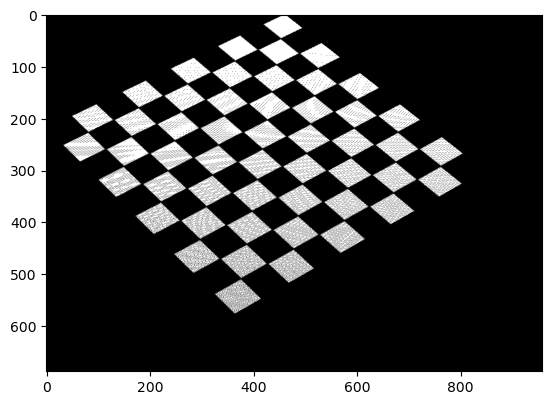

In [42]:
h12h2 = transfer_bilingual(image_h1, H)
plt.imshow(h12h2)

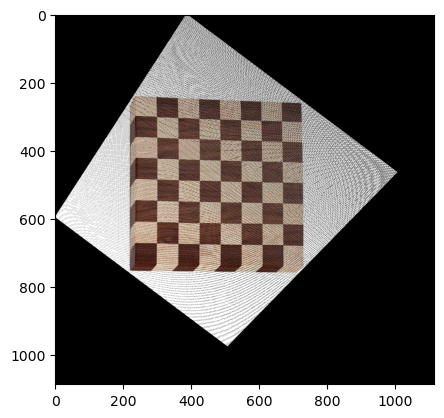

In [43]:
points2 = nodes[4:8] + nodes[0:4]
H2 = homography(points2)
H_1 = np.linalg.inv(H)
h22h1 = transfer_bilingual(image_h2, H2)
plt.imshow(h22h1)

In [44]:
loc = Tk()
nodes_n = []

loc.geometry("1000x1000")
loc.title("part2")
canvas = Canvas(loc, bg='white', width=1080, height=1200)
canvas.pack()

img_bus = Image.open('./img/bus.jpg')
img_bus_tk = ImageTk.PhotoImage(img_bus)
img_canvas = canvas.create_image(0, 0, image=img_bus_tk, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))

text_canvas = canvas.create_text(200, 730, text="Click Order: top left->top right->down left->down right",
                                 font=("Arial", 15))
canvas.create_text(180, 750, text="Position of points:", font=("Arial", 15))


def print_pos_1(e):
    if not e:
        raise ValueError("e is None")
    px, py = e2c(e, canvas)
    points_c = [e.y, e.x, py, px]
    nodes_n.append(points_c)
    index = len(nodes_n)
    canvas.create_text(300 + index * 62, 750, text=f"{index}:(%d,%d)," % (e.y, e.x), font=("Arial", 10))
    print(f"Point {index}: ({e.y}, {e.x}) - ({py}, {px})")


canvas.bind("<ButtonPress-1>", print_pos_1)

loc.mainloop()

Point 1: (214, 582) - (211.0, 582.0)
Point 2: (235, 800) - (232.0, 800.0)
Point 3: (524, 596) - (521.0, 596.0)
Point 4: (470, 804) - (467.0, 804.0)


In [45]:
bus = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
simpsons = cv.imread('./img/simpsons.jpg', cv.IMREAD_COLOR)
bus = cv.cvtColor(bus, cv.COLOR_BGR2RGB)
simpsons = cv.cvtColor(simpsons, cv.COLOR_BGR2RGB)

# plt.imshow(simpsons)

In [46]:
[row, col, c] = simpsons.shape
# lt = [[0, 0, 0, 0]]
# rt = [[0, col - 1, 0, col - 1]]
# lb = [[row - 1, 0, row - 1, 0]]
# rb = [[row - 1, col - 1, row - 1, col - 1]]
# top left, top right, down left, down right
tl = [[0, 0, 0, 0]]
dl = [[row, 0, row, 0]]
tr = [[0, col, 0, col]]
dr = [[row, col, row, col]]
points_add = tl + tr + dl + dr + nodes_n

H3 = homography(points_add)
Simpsons_trans = transfer_bilingual(simpsons, H3)
# plt.imshow(Simpsons_trans)


In [47]:
def add_Simpsons(arr, Simpsons, bus_add):
    if not Simpsons.any():
        raise ValueError("Simpsons is None")
    # add Simpsons to bus
    for i in range(arr[0], arr[1]):
        for j in range(arr[2], arr[3]):
            x = i - arr[0]
            y = j - arr[2]
            if any(Simpsons[x, y] > 0):
                # print(Simpsons[x, y])
                bus_add[i, j] = Simpsons[x, y][:]

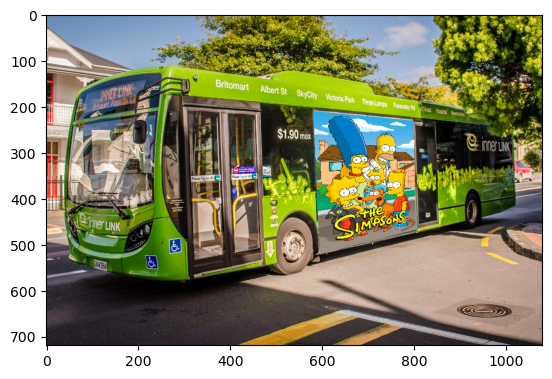

In [48]:
bus_add = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
bus_add = cv.cvtColor(bus_add, cv.COLOR_BGR2RGB)

points_2 = np.array(nodes_n)
arr = np.array([int(np.min(points_2[:, 2])),
                int(np.max(points_2[:, 2])),
                int(np.min(points_2[:, 3])),
                int(np.max(points_2[:, 3]))])
add_Simpsons(arr, Simpsons_trans, bus_add)
plt.imshow(bus_add)
